In [203]:
import sympy
import numpy as np
import time

from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Reaction:
    reactants: List[Tuple[int, int]]  # (species_index, stoichiometry)
    products: List[Tuple[int, int]]   # (species_index, stoichiometry)

        
def generate_stoichiometry_matrix(L, n_reactions, reac_order=1, force_reverse_reactions=False, seed=None, timeout = 3):
    """
    Generate a stoichiometry matrix A given a matrix L (whose nullspace defines conservation laws),
    the number of reactions, and the maximum reaction order.
    
    Args:
        L: sympy.Matrix, the matrix whose nullspace defines conservation laws
        n_reac: int, number of reactions (columns in A)
        reac_order: int, maximum allowed absolute value for stoichiometric coefficients (default 1)
        seed: int or None, random seed for reproducibility
        
    Returns:
        A: sympy.Matrix, the generated stoichiometry matrix
    """
    if seed is not None:
        np.random.seed(seed)
    nullspace = L.nullspace()
    # Check for non-integer elements in nullspace vectors
    for v in nullspace:
        if not all(x == int(x) for x in v):
            raise ValueError("Nullspace vector contains non-integer elements. Please provide a matrix L with integer nullspace vectors.")
    n_null = len(nullspace)
    cols = []
    sub_start_time = time.time()
    for m in range(n_reactions):
        while True:
            coefs = [np.random.randint(-2, 2) for _ in range(n_null)]  # -1, 0, or 1
            zero_col = sympy.zeros(*nullspace[0].shape)
            col = sum((c * v for c, v in zip(coefs, nullspace)), zero_col)
            sum_neg = sum(-x for x in col if x < 0)
            sum_pos = sum(x for x in col if x > 0)
            if (
                all(abs(x) <= reac_order for x in col)
                and sum_neg <= reac_order
                and sum_pos <= reac_order
                and sum_neg != 0
                and sum_pos != 0
                and not any(col == existing for existing in cols)
            ):
                break
        
            if time.time() - sub_start_time > timeout:
                raise ValueError("Timeout reached while generating stoichiometry matrix.")
        cols.append(col)
        if force_reverse_reactions:
            cols.append(-col)
    A = sympy.Matrix.hstack(*cols)
    return A

def build_mass_action_odes(A, Reaction, species_prefix='S', rate_prefix='k'):
    """
    Given a stoichiometry matrix A and a Reaction class, build the mass action ODEs.
    Returns:
        S: tuple of sympy symbols for species concentrations
        k: tuple of sympy symbols for rate constants
        odes: list of sympy expressions for the ODEs
        reaction_network: list of Reaction objects
        rate_exprs: list of sympy expressions for reaction rates
    """
    n_species = A.shape[0]
    n_reactions = A.shape[1]

    # Build reaction network
    reaction_network = []
    for j in range(n_reactions):
        reactants = []
        products = []
        for i in range(n_species):
            stoich = A[i, j]
            if stoich < 0:
                reactants.append((i, -stoich))
            elif stoich > 0:
                products.append((i, stoich))
        reaction_network.append(Reaction(reactants, products))

    # Define symbols
    S = sympy.symbols(f'{species_prefix}1:{n_species+1}')
    k = sympy.symbols(f'{rate_prefix}1:{n_reactions+1}')

    # Build rate expressions
    rate_exprs = []
    for j, rxn in enumerate(reaction_network):
        rate = k[j]
        for idx, stoich in rxn.reactants:
            rate *= S[idx]**stoich
        rate_exprs.append(rate)

    # Build ODEs
    odes = [0 for _ in range(n_species)]
    for j, rxn in enumerate(reaction_network):
        rate = rate_exprs[j]
        for idx, stoich in rxn.reactants:
            odes[idx] -= stoich * rate
        for idx, stoich in rxn.products:
            odes[idx] += stoich * rate

    return S, k, odes, reaction_network, rate_exprs

def random_conservation_laws(n_cons, n_species, probs, seed=None):
    """
    Generate a random set of conservation laws as a sympy.Matrix.

    Args:
        n_cons (int): Number of conservation laws (rows).
        n_species (int): Number of species (columns).
        mc (int): Maximum absolute value for integer elements.
        seed (int or None): Random seed for reproducibility.

    Returns:
        sympy.Matrix: Matrix of shape (n_cons, n_species).
    """
    if seed is not None:
        np.random.seed(seed)
    L = []
    mc = len(probs)
    for _ in range(n_cons):
        while True:
            values = np.arange(mc)  
            row = np.random.choice(values, size=n_species, p=probs)
            if np.any(row != 0):  # Exclude all-zero row
                break
        L.append(row)
    return sympy.Matrix(L)


    # Print the parsed reaction network
# def print_reaction_network(reaction_network):
#     for idx, rxn in enumerate(reaction_network):
#         react_str = ' + '.join([f"S{r[0]+1}{'('+str(r[1])+')' if r[1]>1 else ''}" for r in rxn.reactants]) or '∅'
#         prod_str = ' + '.join([f"S{p[0]+1}{'('+str(p[1])+')' if p[1]>1 else ''}" for p in rxn.products]) or '∅'
#         print(f"R{idx+1}: {react_str} -> {prod_str}")

def print_reaction_network(reaction_network):
    for idx, rxn in enumerate(reaction_network):
        react_str = ' + '.join(
            [ ' + '.join([f"S{r[0]+1}"] * r[1]) for r in rxn.reactants ]
        ) or '∅'
        prod_str = ' + '.join(
            [ ' + '.join([f"S{p[0]+1}"] * p[1]) for p in rxn.products ]
        ) or '∅'
        print(f"R{idx+1}: {react_str} -> {prod_str}")

def compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals):
    ss_response = []
    for input_val in input_vals:
        if input_type == 'rate':
            k_values_copy = k_values.copy()
            k_values_copy[input_idx] = k_values_copy[input_idx] * np.exp(input_val)
            sol = solve_ivp(rhs, t_span, y0, args=(k_values_copy,), t_eval=t_eval, method='LSODA', rtol=1e-5, atol=1e-6)
        elif input_type == 'concentration':
            y0_copy = y0.copy()
            y0_copy[input_idx] = input_val
            sol = solve_ivp(rhs, t_span, y0_copy, args=(k_values,), t_eval=t_eval, method='LSODA', rtol=1e-3, atol=1e-6)
        ss_response.append(sol.y[:, -1])
    return np.array(ss_response)


def count_turning_points(y, eps=1e-8):
    """
    Counts the number of turning points (where the derivative changes sign)
    in a sequence of equally spaced points, ignoring small numerical fluctuations.

    Parameters:
        y (array-like): Sequence of y-values at equally spaced x-values.
        eps (float): Threshold below which the derivative is considered zero.

    Returns:
        int: Number of turning points.
    """
    y = np.asarray(y)
    dy = np.diff(y)
    # Set small derivatives to zero
    dy[np.abs(dy) < eps] = 0
    sign_dy = np.sign(dy)
    # Only count sign changes where both sides are nonzero (not flat)
    sign_changes = (sign_dy[1:] * sign_dy[:-1] < 0) & (sign_dy[1:] != 0) & (sign_dy[:-1] != 0)
    return np.sum(sign_changes)


def count_turning_points_columns(arr,eps=1e-8):
    """
    Counts the number of turning points for each column in a 2D numpy array.
    
    Parameters:
        arr (numpy.ndarray): 2D array where each column contains a sequence of values
        
    Returns:
        numpy.ndarray: Array containing the number of turning points for each column
    """
    arr = np.asarray(arr)
    n_cols = arr.shape[1]
    turning_points = np.zeros(n_cols)
    
    for i in range(n_cols):
        turning_points[i] = count_turning_points(arr[:, i], eps=eps)
        
    return turning_points

def rhs(t, y, k_values):
    return np.array(ode_func(y, k_values)).flatten()


In [100]:
L = sympy.Matrix([
    [1, 2, 0, 1, 0],
    [0, 0, 1, 0, 1]
])

# L = sympy.Matrix([
#     [1, 0, 0, 1, 1, 0],
#     [0, 1, 0, 0, 1, 1],
#     [0, 0, 1, 1, 0, 1],
# ])

# L = sympy.Matrix([
#     [1, 1, 1, 1, 1, 1],
# ])

n_species = 5
n_cons = 2
L = random_conservation_laws(n_cons, n_species, mc=2, seed=None)
print(L)
n_reactions = 4
n_species = L.shape[1]

### check that there are no accidental conservation laws
reac_order = 2

seed = np.random.randint(0, 1000000)

A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, seed=seed)
sympy.pprint(A)

S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)
print(odes)
print_reaction_network(reaction_network)

Matrix([[2, 2, 0, 2, 2], [1, 0, 0, 1, 1]])
⎡1   2   1   -1⎤
⎢              ⎥
⎢0   0   0   0 ⎥
⎢              ⎥
⎢1   0   0   1 ⎥
⎢              ⎥
⎢0   0   -1  0 ⎥
⎢              ⎥
⎣-1  -2  0   1 ⎦
[-S1*k4 + S4*k3 + 2*S5**2*k2 + S5*k1, 0, S1*k4 + S5*k1, -S4*k3, S1*k4 - 2*S5**2*k2 - S5*k1]
R1: S5 -> S1 + S3
R2: S5 + S5 -> S1 + S1
R3: S4 -> S1
R4: S1 -> S3 + S5


In [76]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Suppose S = (S1, S2, ..., S5), k = (k1, ..., k7)
# odes is a list of sympy expressions in S and k

# Create a function for the right-hand side
ode_func = sympy.lambdify((S, k), odes, modules='numpy')

def rhs(t, y, k_values):
    # y: concentrations at time t
    # k_values: array of rate constants
    return np.array(ode_func(y, k_values)).flatten()


# Example initial concentrations and rate constants
#y0 = [1.0, 0.5, 0.2, 1.0, 0.2, 0.5]  # adjust as needed

y0 = 2 * np.random.rand(n_species)
print(y0)
k_values = 5 * np.random.rand(n_reactions)
t_span = (0, 50)                 # time interval
dt = 0.001
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

[1.83816744 0.40326433 0.79023005 1.74082522 1.98182282 0.45838118]


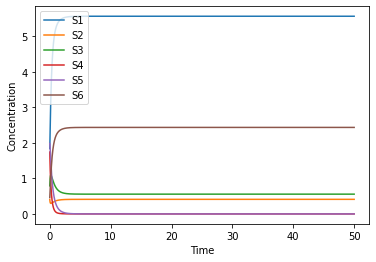

In [77]:
sol = solve_ivp(rhs, t_span, y0, args=(k_values,), t_eval=t_eval)


for i in range(n_species):
    plt.plot(sol.t, sol.y[i], label=f'S{i+1}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

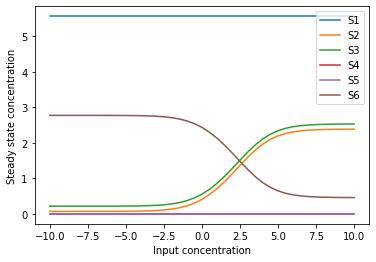

In [83]:
t_span = (0, 500)                 # time interval
dt = 0.01
t_eval = np.linspace(*t_span, int(t_span[1]/dt))  # evaluate at 1000 points (dt = 0.2)

#k_values = 5 * np.random.rand(n_reactions)

# input_type = 'concentration'
# input_idx = 1
# dv = 0.1
# crange = 10
# input_vals =  np.linspace(0, crange, int(crange/dv))

input_type = 'rate'
input_idx = 0
input_vals =  np.linspace(-10, 10, 41)


ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals)

for i in range(ss_response.shape[1]):
    plt.plot(input_vals, ss_response[:, i], label=f'S{i+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()



In [84]:
count_turning_points_columns(ss_response, eps=1e-6)



array([0., 0., 0., 0., 0., 0.])

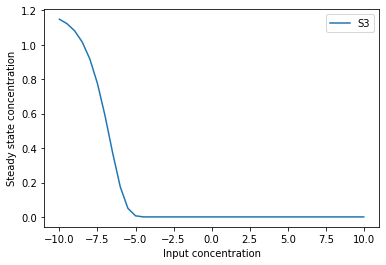

In [63]:
plt.plot(input_vals[:], ss_response[:, 4], label=f'S{2+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()

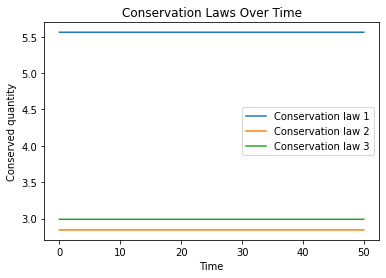

In [85]:
# If L is a sympy Matrix, convert to numpy
L_np = np.array(L).astype(float)  # shape: (n_laws, n_species)
S_sol = sol.y                     # shape: (n_species, n_timepoints)

# Compute conserved quantities at each timepoint
Q = L_np @ S_sol  # shape: (n_laws, n_timepoints)

# Plot each conserved quantity over time
for i in range(Q.shape[0]):
    plt.plot(sol.t, Q[i], label=f'Conservation law {i+1}')
plt.xlabel('Time')
plt.ylabel('Conserved quantity')
plt.legend()
plt.title('Conservation Laws Over Time')
plt.show()

[1  1  1  1  1  1]
[-S1*k9, -S2*k10 + S4*k7 + S5*k4 + S6*k2, -S3*k1 - S3*k5 - S3*k8 + S6*k3, S1*k9 + S3*k5 - S4*k7, S2*k10 + S3*k8 - S5*k4 - S5*k6, S3*k1 + S5*k6 - S6*k2 - S6*k3]
R1: S3 -> S6
R2: S6 -> S2
R3: S6 -> S3
R4: S5 -> S2
R5: S3 -> S4
R6: S5 -> S6
R7: S4 -> S2
R8: S3 -> S5
R9: S1 -> S4
R10: S2 -> S5
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0.]


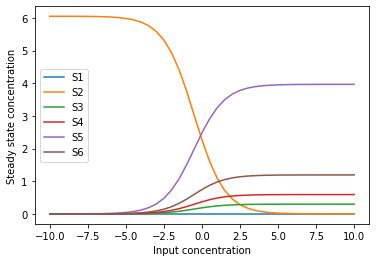

In [256]:
# --- Simulation and Analysis of Random Reaction Networks ---

# Parameters for the system
n_cons = 1           # Number of conservation laws
n_reactions = 10      # Number of reactions
n_species = 6       # Number of species
force_reverse_reactions = False  # Force all reactions to have a reverse reaction
k_fac = 2 if force_reverse_reactions else 1  # Factor to account for reverse reactions in rate constant generation

# Random seed for reproducibility
seed = np.random.randint(0, 1000000)
seed = 10
np.random.seed(seed)

# Probability distribution for conservation law entries (e.g., [2,2] means 0 and 1 equally likely)
reac_order = 1
probs = np.array([2, 200])
probs = probs / sum(probs)

# reac_order = 2
# probs = np.array([3, 3, 1])
# probs = probs / sum(probs)

# Timeouts for random search
outer_timeout = 10   # seconds for the outer loop
inner_timeout = 2    # seconds for the inner loop in generate_stoichiometry_matrix

# Magnitude for initial conditions and rate constants
y_mag = 2
k_mag = 5

# Time span and evaluation points for ODE integration
t_span = (0, 30)  # time interval
dt = 0.01
# Number of time points to evaluate
t_eval = np.linspace(*t_span, int(t_span[1]/dt))

# Input perturbation settings
input_type = 'rate'  # or 'concentration'
input_range = n_reactions  # number of possible input indices
input_vals = np.linspace(-10, 10, 41)  # range of input values to scan

# --- Randomly generate valid conservation laws and stoichiometry matrix ---
success = False
start_time = time.time()
while not success:
    # Sample random conservation laws matrix
    L = random_conservation_laws(n_cons, n_species, probs, seed=None)
    sympy.pprint(L)
    try:
        # Try to generate a valid stoichiometry matrix
        A = generate_stoichiometry_matrix(L, n_reactions, reac_order=reac_order, force_reverse_reactions=force_reverse_reactions, seed=None, timeout=inner_timeout)
        success = True  # Only set to True if no error is raised
    except ValueError as e:
        # If time limit exceeded, raise error
        if time.time() - start_time > outer_timeout:
            raise ValueError("Timeout reached while running outer loop.")
        continue  # Otherwise, try again

# --- Build ODEs and reaction network ---
S, k, odes, reaction_network, rate_exprs = build_mass_action_odes(A, Reaction)

# Print ODEs and reaction network
print(odes)
print_reaction_network(reaction_network)

# --- Set up initial conditions and rate constants ---
y0 = y_mag * np.random.rand(n_species)
k_values = k_mag * np.random.rand(k_fac * n_reactions)

# Lambdify ODEs for numerical integration
ode_func = sympy.lambdify((S, k), odes, modules='numpy')

# --- Compute steady-state response as a function of input ---
# input_idx = 2  # Index of the input to perturb (can loop over input_range if desired)
# ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals)
# print(count_turning_points_columns(ss_response, eps=1e-3))

ss_responses = []
for input_idx in range(input_range):
    ss_response = compute_ss_response_as_function_of_input(rhs, k_values, y0, t_eval, input_type, input_idx, input_vals)
    ss_responses.append(ss_response)
    print(count_turning_points_columns(ss_response, eps=1e-3))


# --- Plot steady-state response curves ---
for i in range(ss_response.shape[1]):
    plt.plot(input_vals, ss_response[:, i], label=f'S{i+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration')
plt.legend()

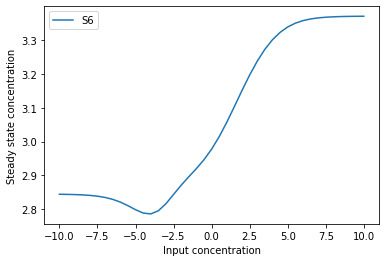

In [239]:
ss_ind = 6
v_ind = 1
plt.plot(input_vals, ss_responses[ss_ind][:, v_ind], label=f'S{i+1}')
plt.xlabel('Input concentration')
plt.ylabel('Steady state concentration') 
plt.legend()

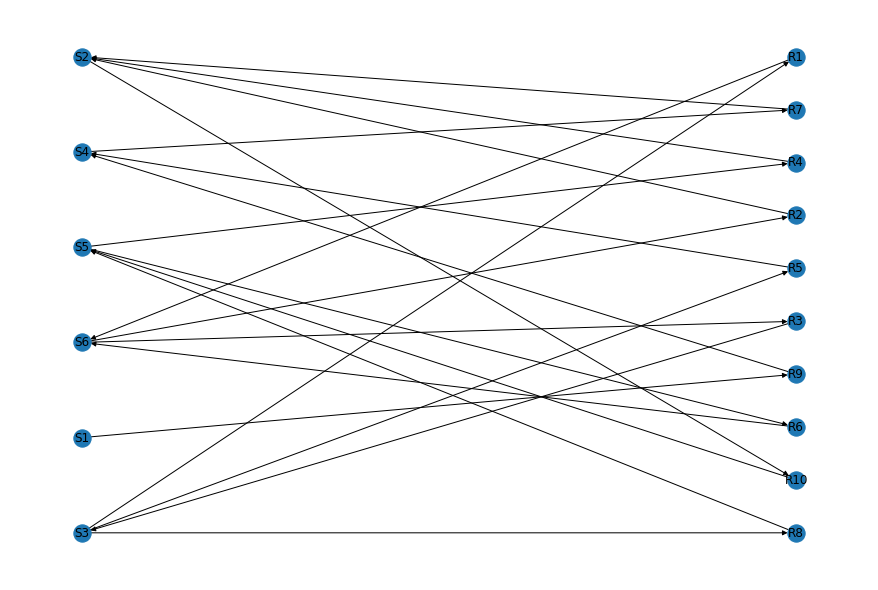

In [257]:
import networkx as nx
import matplotlib.pyplot as plt

def reaction_network_to_bipartite_graph(reaction_network, n_species):
    G = nx.DiGraph()
    # Add species nodes
    for i in range(n_species):
        G.add_node(f"S{i+1}", bipartite='species')
    # Add reaction nodes and edges
    for idx, rxn in enumerate(reaction_network):
        rxn_node = f"R{idx+1}"
        G.add_node(rxn_node, bipartite='reaction')
        # Reactants: edge from species to reaction
        for sidx, stoich in rxn.reactants:
            G.add_edge(f"S{sidx+1}", rxn_node, stoich=stoich, role='reactant')
        # Products: edge from reaction to species
        for sidx, stoich in rxn.products:
            G.add_edge(rxn_node, f"S{sidx+1}", stoich=stoich, role='product')
    return G

# Example usage:
G = reaction_network_to_bipartite_graph(reaction_network, n_species)
#pos = nx.spring_layout(G)
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True)
plt.show()